In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ACTION_SPACE = ('U', 'D', 'L', 'R')
delta = 1e-4 # error threshold
gamma = 0.9 # discounting factor
alpha = 0.1 # learning rate

## Setup

In [5]:
class Grid:
    def __init__(self, rows, columns, start):
        self.rows = rows
        self.columns = columns
        self.i = start[0]
        self.j = start[1]

    def set_rewards_actions(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions
    
    def get_state(self):
        return (self.i, self.j)

    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]

    def get_next_state(self, s, a):
        i, j = s[0], s[1]
        if a in self.actions[(i, j)]:
            if a == 'U':
                i -= 1
            elif a == 'D':
                i += 1
            elif a == 'L':
                j -= 1
            elif a == 'R':
                j += 1
        return i, j
    
    def move(self, a):
        if a in self.actions[(self.i, self.j)]:
            if a == 'U':
                self.i -= 1
            elif a == 'D':
                self.i += 1
            elif a == 'L':
                self.j -= 1
            elif a == 'R':
                self.j += 1
        return self.rewards.get((self.i, self.j), 0)
    
    def undo_move(self, a):
        if a == 'U':
            self.i += 1
        elif a == 'D':
            self.i -= 1
        elif a == 'L':
            self.j += 1
        elif a == 'R':
            self.j -= 1
        assert (self.get_state() in self.all_states())
    
    def is_terminal(self, s):
        return s not in self.actions

    def game_over(self):
        return (self.i, self.j) not in self.actions

    def all_states(self):
        return set(self.actions.keys() | self.rewards.keys())

In [6]:
def grid_standard():
    g = Grid(3, 4, (2, 0))
    rewards = {
        (0,3): 1,
        (1,3): -1
    }
    
    actions = {
        (0, 0): ('D', 'R'),
        (0, 1): ('L', 'R'),
        (0, 2): ('L', 'D', 'R'),
        (1, 0): ('U', 'D'),
        (1, 2): ('U', 'D', 'R'),
        (2, 0): ('U', 'R'),
        (2, 1): ('L', 'R'),
        (2, 2): ('U', 'L', 'R'),
        (2, 3): ('U', 'L')
    }

    g.set_rewards_actions(rewards, actions)

    return g

In [7]:
def grid_negative(step_cost=-0.1):
    # in this game we want to try to minimize the number of moves
    # so we will penalize every move
    g = grid_standard()
    g.rewards.update({
        (0, 0): step_cost,
        (0, 1): step_cost,
        (0, 2): step_cost,
        (1, 0): step_cost,
        (1, 2): step_cost,
        (2, 0): step_cost,
        (2, 1): step_cost,
        (2, 2): step_cost,
        (2, 3): step_cost,
    })
    return g

In [8]:
def print_values(V, g):
    for i in range(g.rows):
        print("-------------------------")
        for j in range(g.columns):
            v = V.get((i, j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="")
        print("")

def print_policy(P, g):
    for i in range(g.rows):
        print("-------------------------")
        for j in range(g.columns):
            a = P.get((i, j), ' ')
            print(" %s |" % a, end="")
        print("")

In [9]:
def t_probs_rewards(g):
    transition_probs = {}

    rewards = {}

    for i in range(g.rows):
        for j in range(g.columns):
            s = (i, j)
            if not g.is_terminal(s):
                for a in ACTION_SPACE:
                    s_next = g.get_next_state(s, a)
                    transition_probs[(s, a, s_next)] = 1 # prob of s with action to reach s_next is 1 because deterministic
                    if s_next in g.rewards:
                        rewards[(s, a, s_next)] = g.rewards[s_next]
    return transition_probs, rewards

In [10]:
def evaluate_deterministic_policy(g, policy):
    V = {}
    for s in g.all_states():
        V[s] = 0
    iterations = 0

    while True:
        biggest_change = 0
        for s in g.all_states():
            old_v = V[s]
            new_v = 0
            for a in ACTION_SPACE:
                for s_next in g.all_states():
                    action_prob = 1 if policy.get(s) == a else 0

                    r = rewards.get((s, a, s_next), 0)

                    new_v += action_prob * transition_probs.get((s, a, s_next), 0) * (r + gamma * V[s_next])

            V[s] = new_v
            biggest_change = max(biggest_change, np.abs(old_v - V[s]))

        iterations += 1
        if biggest_change < delta:
            break

    return V

In [11]:
def get_optimal_policy(g, policy):
    while True:
        V = evaluate_deterministic_policy(g, policy)

        is_policy_converged = True
        for s in g.actions.keys():
            old_a = policy[s]
            new_a = None
            best_value = float('-inf')

            for a in ACTION_SPACE:
                v = 0
                for s_next in g.all_states():
                    r = rewards.get((s, a, s_next), 0)
                    v += transition_probs.get((s, a, s_next), 0) * (r + gamma * V[s_next])

                if v > best_value:
                    best_value = v
                    new_a = a
            
            policy[s] = new_a

            if new_a != old_a:
                is_policy_converged = False
            
        if is_policy_converged:
            break
    return V, policy

In [12]:
# initialize variable
g = grid_standard()

# random policy
policy = {}
for s in g.actions.keys():
    policy[s] = np.random.choice(ACTION_SPACE)

print("initial policy")
print_policy(policy, g)
print("")

transition_probs, rewards = t_probs_rewards(g)

V, policy = get_optimal_policy(g, policy)
print("optimal policy")
print_policy(policy, g)
print("V")
print_values(V, g)

initial policy
-------------------------
 L | U | U |   |
-------------------------
 D |   | U |   |
-------------------------
 R | D | L | U |

optimal policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | R | U | L |
V
-------------------------
 0.81| 0.90| 1.00| 0.00|
-------------------------
 0.73| 0.00| 0.90| 0.00|
-------------------------
 0.66| 0.73| 0.81| 0.73|


## Monte Carlo

In [13]:
def random_action(a, eps=0.1):
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ACTION_SPACE)

In [14]:
def play_game(g, policy):
    start_states = list(g.actions.keys())
    start_idx = np.random.choice(len(start_states))
    g.set_state(start_states[start_idx])

    s = g.get_state()
    states_and_rewards = [(s, 0)] # at the start reward = 0

    while not g.game_over(): # update (s, r) for every state visited based on policy
        a = policy[s]
        a = random_action(a)
        r = g.move(a)
        s = g.get_state()
        states_and_rewards.append((s, r))

    G = 0
    states_and_returns = []
    first = True

    for s, r in reversed(states_and_rewards): # backwards iteration from terminal state
        if first:
            first = False
        else:
            states_and_returns.append((s, G))
        
        G = r + gamma * G
    states_and_returns.reverse()
    return states_and_returns

In [15]:
def play_game_random_start_action(g, policy):
    # start_states = list(g.actions.keys())
    # start_idx = np.random.choice(len(start_states))
    s = (2, 0)
    g.set_state(s)

    a = random_action(policy[s])

    states_actions_rewards = [(s, a, 0)]
    seen_states = set() # record visited states
    seen_states.add(s)
    n_steps = 0

    while True:
        old_s = g.get_state()
        r = g.move(a)
        s = g.get_state()
        n_steps += 1

        # if s in seen_states: # prevent infinite looping in several states because using standard grid
        #     r = -0.1 / n_steps
        #     states_actions_rewards.append((s, None, r))
        if old_s == s:
            states_actions_rewards.append((s, None, -100))
            break
        elif g.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = random_action(policy[s])
            states_actions_rewards.append((s, a, r))
        seen_states.add(s)

    G = 0
    states_actions_returns = []
    first = True

    for s, a, r in reversed(states_actions_rewards): # backwards iteration from terminal state
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        
        G = r + gamma * G
    states_actions_returns.reverse()
    return states_actions_returns

In [16]:
def max_dict(d):
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

### Monte Carlo Evaluation

In [17]:
def monte_carlo(g, policy, V, returns, num_of_iter):
    for t in range(num_of_iter):
        states_and_returns = play_game(g, policy)
        seen_states = set()

        for s, G in states_and_returns:
            if s not in seen_states:
                returns[s].append(G)
                V[s] = np.mean(returns[s])
                seen_states.add(s)
    
    return V, policy

### Monte Carlo Improvement

In [18]:
def monte_carlo_improvement(g, policy, Q, returns, deltas, num_of_iter):
    for t in range(num_of_iter):
        if t % 1000 == 0:
            print(t)

        states_actions_returns = play_game_random_start_action(g, policy)
        seen_states_actions = set()

        biggest_change = 0
        for s, a, G in states_actions_returns:
            sa = (s, a)
            if sa not in seen_states_actions:
                old_Q = Q[s][a]
                returns[sa].append(G)
                Q[s][a] = np.mean(returns[sa])
                biggest_change = max(biggest_change, np.abs(old_Q - Q[s][a]))
                seen_states_actions.add(sa)

        deltas.append(biggest_change)

        for s in policy.keys():
            policy[s] = max_dict(Q[s])[0]
    
    return Q, policy, deltas

### Run Monte Carlo

In [19]:
g = grid_standard()

print("rewards:")
print_values(g.rewards, g)

policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L',
}

V = {}
returns = {}

for s in g.all_states():
    if s in g.actions:
        returns[s] = []
    else:
        V[s] = 0

V, policy = monte_carlo(g, policy, V, returns, 5000)

print("values")
print_values(V, g)
print("policy")
print_policy(policy, g)

rewards:
-------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------
 0.00| 0.00| 0.00| 0.00|
values
-------------------------
 0.78| 0.88| 0.99| 0.00|
-------------------------
 0.70| 0.00| 0.83| 0.00|
-------------------------
 0.62| 0.56| 0.74| 0.63|
policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | L | U | L |


rewards:
-------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------
 0.00| 0.00| 0.00| 0.00|
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


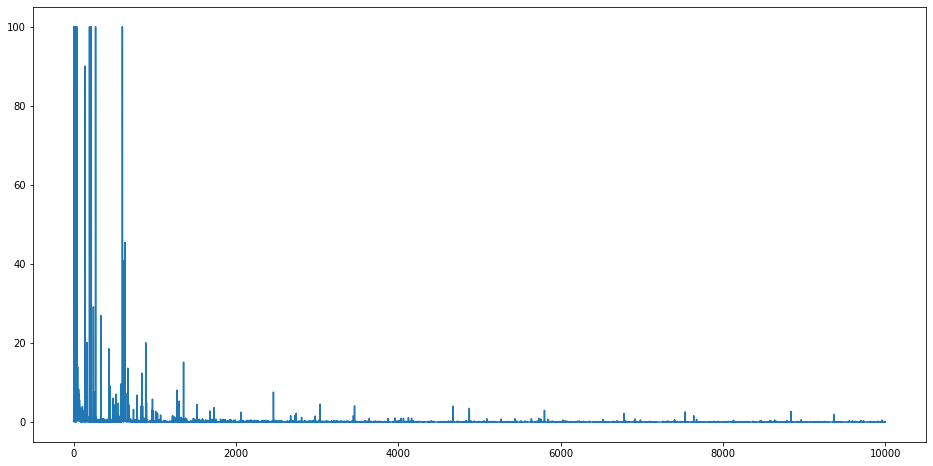

final values
-------------------------
-6.40|-1.64| 1.00| 0.00|
-------------------------
-10.53| 0.00|-1.00| 0.00|
-------------------------
-14.49|-22.75|-18.64|-1.00|
optimal policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | R |   |
-------------------------
 U | L | R | U |


In [20]:
g = grid_standard()

print("rewards:")
print_values(g.rewards, g)

policy = {}
for s in list(g.actions.keys()):
    policy[s] = np.random.choice(ACTION_SPACE)

Q = {}
returns = {}
for s in g.all_states():
    if s in g.actions:
        Q[s] = {}
        for a in ACTION_SPACE:
            Q[s][a] = 0
            returns[(s,a)] = []


deltas = []

Q, policy, deltas = monte_carlo_improvement(g, policy, Q, returns, deltas, 10000)

plt.figure(figsize=(16,8))
plt.plot(deltas)
plt.show()

V = {}
for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]
print("final values")
print_values(V, g)


print("optimal policy")
print_policy(policy, g)

## TD0

In [21]:
def random_action_td(a, eps=0.1):
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ACTION_SPACE)

In [22]:
def play_game_td(g, policy):
    s = (2, 0)
    g.set_state(s)
    states_and_rewards = [(s, 0)] # at the start reward = 0

    while not g.game_over(): # update (s, r) for every state visited based on policy
        a = policy[s]
        a = random_action_td(a)
        r = g.move(a)
        s = g.get_state()
        states_and_rewards.append((s, r))

    return states_and_rewards

In [23]:
def TD0(g, policy, V, num_of_iter):
    for it in range(num_of_iter):
        states_and_rewards = play_game_td(g, policy)

        for t in range(len(states_and_rewards) - 1):
            s, _ = states_and_rewards[t]
            s_next, r = states_and_rewards[t+1]
            V[s] = V[s] + alpha * (r + gamma * V[s_next] - V[s])
    
    return V, policy

In [24]:
g = grid_standard()

print("rewards:")
print_values(g.rewards, g)

policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
}

V = {}

for s in g.all_states():
    V[s] = 0

V, policy = TD0(g, policy, V, 5000)

print("values")
print_values(V, g)
print("policy")
print_policy(policy, g)

rewards:
-------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------
 0.00| 0.00| 0.00| 0.00|
values
-------------------------
 0.73| 0.80| 0.93| 0.00|
-------------------------
 0.65| 0.00|-0.96| 0.00|
-------------------------
 0.59|-0.78|-0.88|-0.99|
policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | R |   |
-------------------------
 U | R | R | U |


## SARSA

rewards:
-------------------------
-0.10|-0.10|-0.10| 1.00|
-------------------------
-0.10| 0.00|-0.10|-1.00|
-------------------------
-0.10|-0.10|-0.10|-0.10|
0
2000
4000
6000
8000


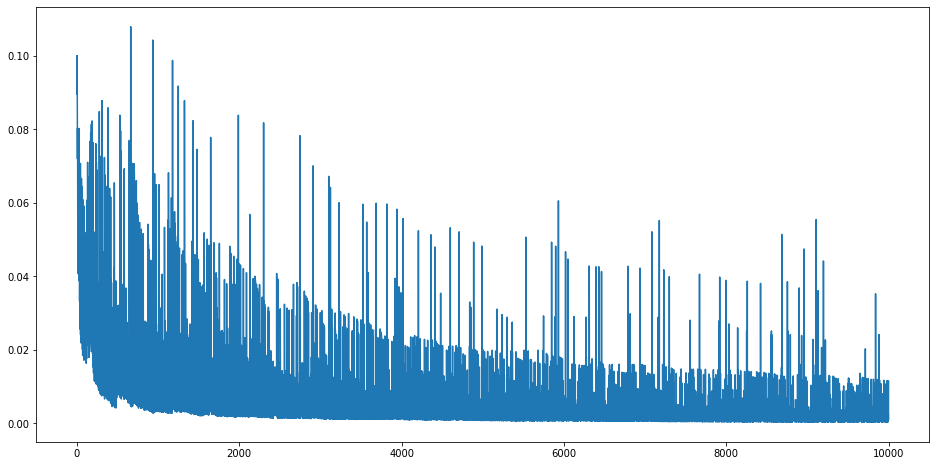

update counts:
-------------------------
 0.18| 0.18| 0.16| 0.00|
-------------------------
 0.18| 0.00| 0.05| 0.00|
-------------------------
 0.18| 0.03| 0.04| 0.01|
final values
-------------------------
 0.34| 0.60| 1.00| 0.00|
-------------------------
 0.12| 0.00| 0.60| 0.00|
-------------------------
-0.07|-0.06| 0.18|-0.07|
optimal policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | R | U | L |


In [25]:
g = grid_negative()

print("rewards:")
print_values(g.rewards, g)

Q = {}
for s in g.all_states():
    Q[s] = {}
    for a in ACTION_SPACE:
        Q[s][a] = 0

update_counts = {}
update_counts_sa = {}
for s in g.all_states():
    update_counts_sa[s] = {}
    for a in ACTION_SPACE:
        update_counts_sa[s][a] = 1.0

t = 1.0
deltas = []
for it in range(10000):
    if it % 100 == 0:
        t += 1e-3
    
    if it % 2000 == 0:
        print(it)
    
    s = (2, 0)
    g.set_state(s)

    a = max_dict(Q[s])[0]
    a = random_action_td(a, eps=0.5/t)
    biggest_change = 0
    while not g.game_over():
        r = g.move(a)
        s_next = g.get_state()

        a_next = max_dict(Q[s_next])[0]
        a_next = random_action_td(a_next, eps=0.5/t)

        alp = alpha / update_counts_sa[s][a] # update learning rate as learning
        update_counts_sa[s][a] += 0.005
        old_qsa = Q[s][a]
        Q[s][a] = Q[s][a] + alp * (r + gamma * Q[s_next][a_next] - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        update_counts[s] = update_counts.get(s, 0) + 1 # to know how often Q(s) updated

        s = s_next
        a = a_next

    deltas.append(biggest_change)

plt.figure(figsize=(16, 8))
plt.plot(deltas)
plt.show()

policy = {}
V = {}

for s in list(g.actions.keys()):
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

print("update counts:")
total = np.sum(list(update_counts.values()))
for k, v in update_counts.items():
    update_counts[k] = float(v) / total
print_values(update_counts, g)

print("final values")
print_values(V, g)


print("optimal policy")
print_policy(policy, g)

Q-Learning

rewards:
-------------------------
-0.10|-0.10|-0.10| 1.00|
-------------------------
-0.10| 0.00|-0.10|-1.00|
-------------------------
-0.10|-0.10|-0.10|-0.10|
0
2000
4000
6000
8000


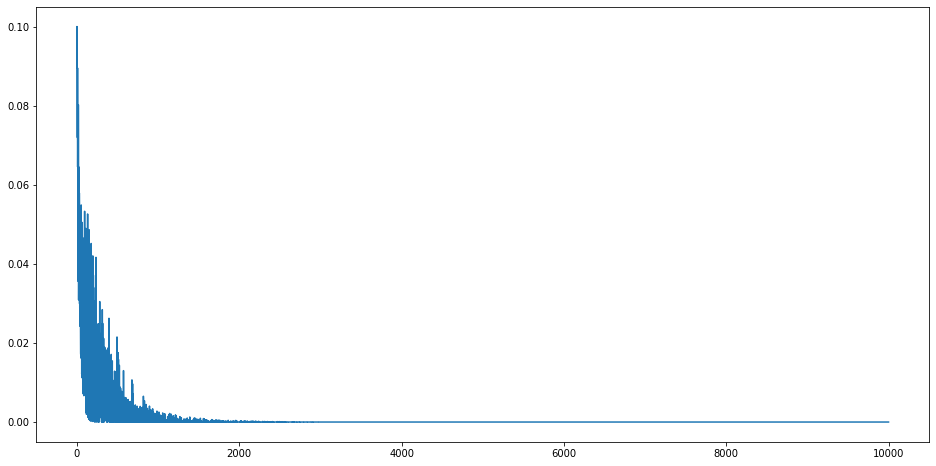

update counts:
-------------------------
 0.09| 0.10| 0.15| 0.00|
-------------------------
 0.08| 0.00| 0.11| 0.00|
-------------------------
 0.18| 0.13| 0.13| 0.02|
final values
-------------------------
 0.62| 0.80| 1.00| 0.00|
-------------------------
 0.46| 0.00| 0.80| 0.00|
-------------------------
 0.31| 0.46| 0.62| 0.46|
optimal policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | R | U | L |


In [26]:
g = grid_negative()

print("rewards:")
print_values(g.rewards, g)

Q = {}
for s in g.all_states():
    Q[s] = {}
    for a in ACTION_SPACE:
        Q[s][a] = 0

update_counts = {}
update_counts_sa = {}
for s in g.all_states():
    update_counts_sa[s] = {}
    for a in ACTION_SPACE:
        update_counts_sa[s][a] = 1.0

t = 1.0
deltas = []
for it in range(10000):
    if it % 100 == 0:
        t += 1e-3
    
    if it % 2000 == 0:
        print(it)
    
    s = (2, 0)
    g.set_state(s)

    a = max_dict(Q[s])[0]
    biggest_change = 0
    while not g.game_over():
        a = random_action_td(a, eps=0.5/t)
        r = g.move(a)
        s_next = g.get_state()

        alp = alpha / update_counts_sa[s][a] # update learning rate as learning
        update_counts_sa[s][a] += 0.005

        a_next, max_q_s2_a2 = max_dict(Q[s_next])

        old_qsa = Q[s][a]
        Q[s][a] = Q[s][a] + alp * (r + gamma * max_q_s2_a2 - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        update_counts[s] = update_counts.get(s, 0) + 1 # to know how often Q(s) updated

        s = s_next
        a = a_next

    deltas.append(biggest_change)

plt.figure(figsize=(16, 8))
plt.plot(deltas)
plt.show()

policy = {}
V = {}

for s in list(g.actions.keys()):
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

print("update counts:")
total = np.sum(list(update_counts.values()))
for k, v in update_counts.items():
    update_counts[k] = float(v) / total
print_values(update_counts, g)

print("final values")
print_values(V, g)


print("optimal policy")
print_policy(policy, g)

## Approximation TD0

In [27]:
class Model:
    def __init__(self):
        self.theta = np.random.randn(4) / 2
    def s2x(self, s):
        return np.array([s[0] - 1, s[1] - 1.5, s[0] * s[1] - 3, 1]) # feature extraction
    def predict(self, s):
        x = self.s2x(s)
        return self.theta.dot(x)
    def grad(self, s):
        return self.s2x(s)

rewards:
-------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------
 0.00| 0.00| 0.00| 0.00|


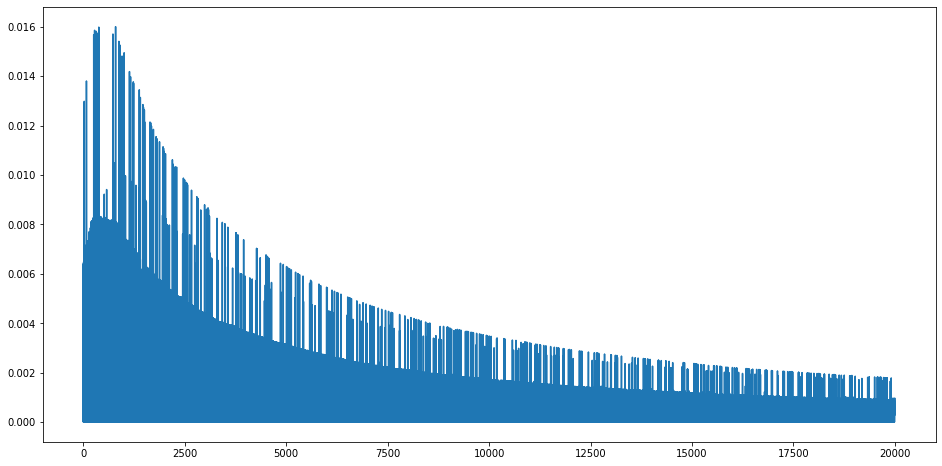

values
-------------------------
 6.75| 5.00| 3.25| 0.00|
-------------------------
 4.27| 0.00|-2.82| 0.00|
-------------------------
 1.80|-3.54|-8.89|-14.23|
policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | R |   |
-------------------------
 U | R | R | U |


In [37]:
g = grid_standard()

print("rewards:")
print_values(g.rewards, g)

policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
}

model = Model()
deltas = []
k = 1.0
alpha = 0.001

for it in range(20000):
    if it % 10 == 0:
        k += 0.01
    alp = alpha / k
    biggest_change = 0
    states_and_rewards = play_game(g, policy)

    for t in range(len(states_and_rewards) - 1):
        s, _ = states_and_rewards[t]
        s_next, r = states_and_rewards[t+1]

        old_theta = model.theta.copy()
        if g.is_terminal(s_next):
            target = r
        else:
            target = r + gamma * (model.predict(s_next))
        model.theta += alp * (target - model.predict(s)) * model.grad(s)
        biggest_change = max(biggest_change, np.abs(old_theta - model.theta).sum())
    deltas.append(biggest_change)

plt.figure(figsize=(16, 8))
plt.plot(deltas)
plt.show()

V = {}
for s in g.all_states():
    if s in list(g.actions.keys()):
        V[s] = model.predict(s)
    else:
        V[s] = 0

print("values")
print_values(V, g)
print("policy")
print_policy(policy, g)

## Approximation SARSA

In [34]:
SA2IDX = {}
IDX = 0

In [42]:
class Model_SARSA:
    def __init__(self):
        self.theta = np.random.randn(25) / np.sqrt(25)
    def sa2x(self, s, a): # feature extraction
        return np.array([
            s[0] - 1                    if a =='U' else 0,
            s[1] - 1.5                  if a =='U' else 0,
            (s[0] * s[1] - 3) / 3       if a =='U' else 0,
            (s[0] * s[0] - 2) / 2       if a =='U' else 0,
            (s[1] * s[1] - 4.5) / 4.5   if a =='U' else 0,
            1                           if a =='U' else 0,
            s[0] - 1                    if a =='D' else 0,
            s[1] - 1.5                  if a =='D' else 0,
            (s[0] * s[1] - 3) / 3       if a =='D' else 0,
            (s[0] * s[0] - 2) / 2       if a =='D' else 0,
            (s[1] * s[1] - 4.5) / 4.5   if a =='D' else 0,
            1                           if a =='D' else 0,
            s[0] - 1                    if a =='L' else 0,
            s[1] - 1.5                  if a =='L' else 0,
            (s[0] * s[1] - 3) / 3       if a =='L' else 0,
            (s[0] * s[0] - 2) / 2       if a =='L' else 0,
            (s[1] * s[1] - 4.5) / 4.5   if a =='L' else 0,
            1                           if a =='L' else 0,
            s[0] - 1                    if a =='R' else 0,
            s[1] - 1.5                  if a =='R' else 0,
            (s[0] * s[1] - 3) / 3       if a =='R' else 0,
            (s[0] * s[0] - 2) / 2       if a =='R' else 0,
            (s[1] * s[1] - 4.5) / 4.5   if a =='R' else 0,
            1                           if a =='R' else 0,
            1
        ]) 
    def predict(self, s, a):
        x = self.sa2x(s, a)
        return self.theta.dot(x)
    def grad(self, s, a):
        return self.sa2x(s, a)

In [43]:
def getQs(model, s):
    Qs = {}
    for a in ACTION_SPACE:
        q_sa = model.predict(s, a)
        Qs[a] = q_sa
    return Qs

rewards:
-------------------------
-0.10|-0.10|-0.10| 1.00|
-------------------------
-0.10| 0.00|-0.10|-1.00|
-------------------------
-0.10|-0.10|-0.10|-0.10|


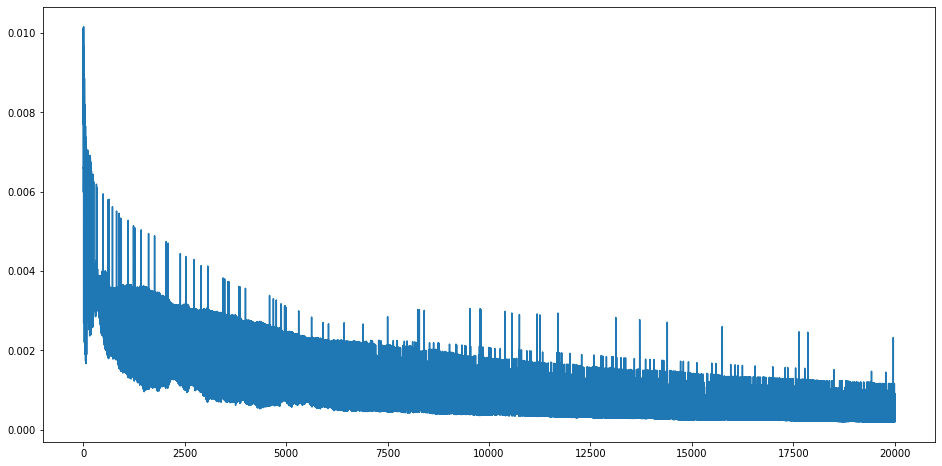

values
-------------------------
 0.54| 0.72| 1.01| 0.00|
-------------------------
 0.37| 0.00| 0.39| 0.00|
-------------------------
 0.16| 0.04|-0.03|-0.07|
policy
-------------------------
 R | R | R |   |
-------------------------
 U |   | U |   |
-------------------------
 U | U | U | U |


In [51]:
g = grid_negative(step_cost=-0.1)

print("rewards:")
print_values(g.rewards, g)

for s in g.all_states():
    SA2IDX[s] = {}
    for a in ACTION_SPACE:
        SA2IDX[s][a] = IDX
        IDX += 1

model = Model_SARSA()
deltas = []
t = 1.0
t2 = 1.0
alpha = 0.001

for it in range(20000):
    if it % 100 == 0:
        t += 0.01
        t2 += 0.01
    alp = alpha / t2
    biggest_change = 0

    s = (2, 0)
    g.set_state(s)

    Qs = getQs(model, s)

    a = max_dict(Qs)[0]
    a = random_action_td(a, eps=0.5/t)

    while not g.game_over():
        r = g.move(a)
        s_next = g.get_state()

        old_theta = model.theta.copy()
        if g.is_terminal(s_next):
            model.theta += alp * (r - model.predict(s, a)) * model.grad(s, a)
        else:
            Qs_next = getQs(model, s_next)
            a_next = max_dict(Qs_next)[0]
            a_next = random_action_td(a_next, eps=0.5/t)

            model.theta += alp * (r + gamma * model.predict(s_next, a_next) - model.predict(s, a)) * model.grad(s, a)

            s = s_next
            a = a_next

        biggest_change = max(biggest_change, np.abs(old_theta - model.theta).sum())
    deltas.append(biggest_change)

plt.figure(figsize=(16, 8))
plt.plot(deltas)
plt.show()

policy = {}
V = {}
Q = {}
for s in g.actions.keys():
    Qs = getQs(model, s)
    Q[s] = Qs
    a, max_q = max_dict(Qs)
    policy[s] = a
    V[s] = max_q

print("values")
print_values(V, g)
print("policy")
print_policy(policy, g)